In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD, AdamW
from torch import nn

from sklearn.feature_extraction.text import TfidfVectorizer
from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import logistic_regresion as lr
import singletask_dep as st
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoding_type = 'brk'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']

vocab_dep = st.Vocabulary(data['train'],encoding_type)

vectorizer = TfidfVectorizer()

vectorizer.fit_transform(list(convai_train.keys()))

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn2(convai_train,['about','to','as'],vocab=vocab_dep,tfidf=vectorizer) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn2(convai_val,['about','to','as'],vocab=vocab_dep,tfidf=vectorizer) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,tfidf=True,deps=True)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,tfidf=True,deps=True)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn2(md_data,['about','to','as'],vocab=vocab_dep,tfidf=vectorizer) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,tfidf=True,deps=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# ABOUT

In [13]:
max_sequence_len = 15088
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [14]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep)

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6806548287644204 	 Validation loss: 0.6796244039373883 	 
  1%|          | 574/57400 [00:12<19:24, 48.80it/s]
Epoch 2 	 Training loss: 0.6710333057812282 	 Validation loss: 0.6713087589053784 	 
  2%|▏         | 1148/57400 [00:22<14:12, 66.01it/s]
Epoch 3 	 Training loss: 0.6652412294095401 	 Validation loss: 0.6654319227752039 	 
  3%|▎         | 1722/57400 [00:31<13:36, 68.17it/s]
Epoch 4 	 Training loss: 0.6613030109671351 	 Validation loss: 0.6610836568525282 	 
  4%|▍         | 2296/57400 [00:40<12:56, 71.01it/s]
Epoch 5 	 Training loss: 0.6578211093821177 	 Validation loss: 0.6575958516638157 	 
  5%|▌         | 2870/57400 [00:49<13:10, 68.94it/s]
Epoch 6 	 Training loss: 0.6548668908325221 	 Validation loss: 0.6548038286677862 	 
  6%|▌         | 3444/57400 [00:58<12:50, 70.03it/s]
Epoch 7 	 Training loss: 0.6519333835470552 	 Validation loss: 0.651935007612584 	 
  7%|▋         | 4018/57400 [01:07<12:44, 69.83it/s]
Epoch 8 	 Training loss: 0.649310958

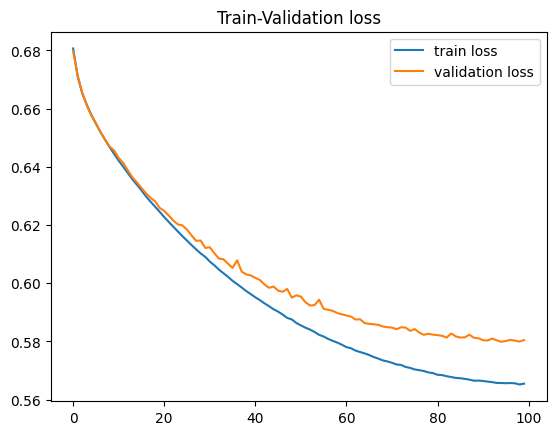

In [15]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_about1'
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [16]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5905612244897959, 'precision': 0.5905612244897959, 'f1': 0.5905612244897959, 'accuracy': 0.5905612244897959}
MALE {'recall': 0.8541666666666666, 'precision': 0.8541666666666666, 'f1': 0.8541666666666666, 'accuracy': 0.8541666666666666}
FEMALE {'recall': 0.3375, 'precision': 0.3375, 'f1': 0.3375, 'accuracy': 0.3375} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5681818181818182, 'precision': 0.5681818181818182, 'f1': 0.5681818181818182, 'accuracy': 0.5681818181818182}
MALE {'recall': 0.8223844282238443, 'precision': 0.8223844282238443, 'f1': 0.8223844282238444, 'accuracy': 0.8223844282238443}
FEMALE {'recall': 0.29396325459317585, 'precision': 0.29396325459317585, 'f1': 0.29396325459317585, 'accuracy': 0.29396325459317585} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.560625814863103, 'precision': 0.560625814863103, 'f1': 0.560625814863103, 'accuracy': 0.560625814863103}
MALE {'recall': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.681126955286551 	 Validation loss: 0.6806903885582746 	 
  1%|          | 574/57400 [00:08<13:20, 71.02it/s]
Epoch 2 	 Training loss: 0.6739383650366022 	 Validation loss: 0.6734624818219976 	 
  2%|▏         | 1148/57400 [00:17<13:06, 71.53it/s]
Epoch 3 	 Training loss: 0.6670980864700955 	 Validation loss: 0.666964226860111 	 
  3%|▎         | 1722/57400 [00:26<13:18, 69.74it/s]
Epoch 4 	 Training loss: 0.6626859151527856 	 Validation loss: 0.663478966486656 	 
  4%|▍         | 2296/57400 [00:35<12:53, 71.20it/s]
Epoch 5 	 Training loss: 0.6592525485708323 	 Validation loss: 0.6607214586209442 	 
  5%|▌         | 2870/57400 [00:43<12:21, 73.53it/s]
Epoch 6 	 Training loss: 0.6561114845167885 	 Validation loss: 0.6576767594127332 	 
  6%|▌         | 3444/57400 [00:52<12:27, 72.16it/s]
Epoch 7 	 Training loss: 0.653478939358781 	 Validation loss: 0.6546732914649834 	 
  7%|▋         | 4018/57400 [01:01<12:29, 71.20it/s]
Epoch 8 	 Training loss: 0.650718783563

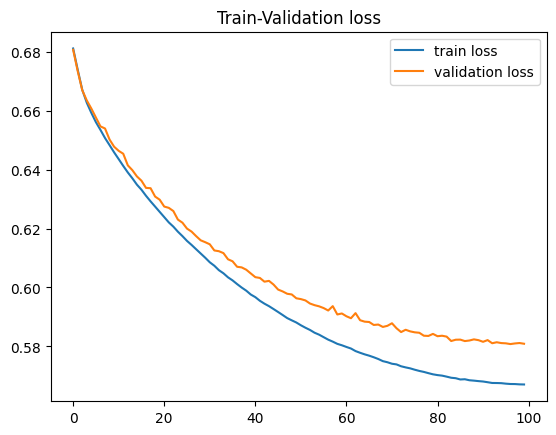

In [17]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_about2'
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5943877551020408, 'precision': 0.5943877551020408, 'f1': 0.5943877551020408, 'accuracy': 0.5943877551020408}
MALE {'recall': 0.84375, 'precision': 0.84375, 'f1': 0.84375, 'accuracy': 0.84375}
FEMALE {'recall': 0.355, 'precision': 0.355, 'f1': 0.35500000000000004, 'accuracy': 0.355} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.571969696969697, 'precision': 0.571969696969697, 'f1': 0.571969696969697, 'accuracy': 0.571969696969697}
MALE {'recall': 0.8223844282238443, 'precision': 0.8223844282238443, 'f1': 0.8223844282238444, 'accuracy': 0.8223844282238443}
FEMALE {'recall': 0.30183727034120733, 'precision': 0.30183727034120733, 'f1': 0.30183727034120733, 'accuracy': 0.30183727034120733} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5567144719687093, 'precision': 0.5567144719687093, 'f1': 0.5567144719687093, 'accuracy': 0.5567144719687093}
MALE {'recall': 0.797979797979798, 'precision': 0.

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6804702772080691 	 Validation loss: 0.6798110260801801 	 
  1%|          | 574/57400 [00:08<13:36, 69.62it/s]
Epoch 2 	 Training loss: 0.6712507511057505 	 Validation loss: 0.6679160584837703 	 
  2%|▏         | 1148/57400 [00:17<13:05, 71.63it/s]
Epoch 3 	 Training loss: 0.6650598771896097 	 Validation loss: 0.6631320260338864 	 
  3%|▎         | 1722/57400 [00:26<13:16, 69.91it/s]
Epoch 4 	 Training loss: 0.661407145369759 	 Validation loss: 0.6593285687899185 	 
  4%|▍         | 2296/57400 [00:35<12:40, 72.49it/s]
Epoch 5 	 Training loss: 0.6581912786287714 	 Validation loss: 0.6565517641730227 	 
  5%|▌         | 2870/57400 [00:44<12:21, 73.50it/s]
Epoch 6 	 Training loss: 0.6553787568305012 	 Validation loss: 0.6543430271795241 	 
  6%|▌         | 3444/57400 [00:53<12:42, 70.79it/s]
Epoch 7 	 Training loss: 0.6525173785379124 	 Validation loss: 0.653064801531323 	 
  7%|▋         | 4018/57400 [01:02<12:26, 71.53it/s]
Epoch 8 	 Training loss: 0.6499100781

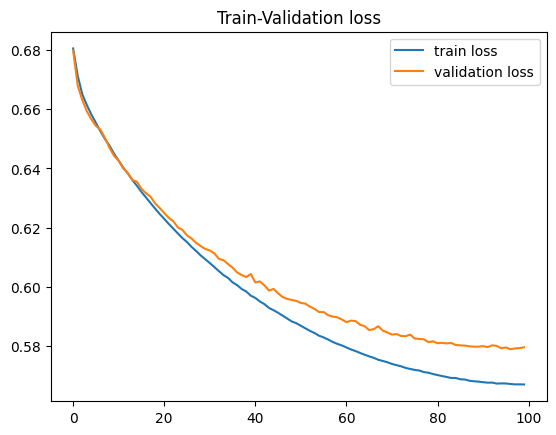

In [19]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_about3'
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [20]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6058673469387755, 'precision': 0.6058673469387755, 'f1': 0.6058673469387755, 'accuracy': 0.6058673469387755}
MALE {'recall': 0.8723958333333334, 'precision': 0.8723958333333334, 'f1': 0.8723958333333334, 'accuracy': 0.8723958333333334}
FEMALE {'recall': 0.35, 'precision': 0.35, 'f1': 0.35, 'accuracy': 0.35} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.553030303030303, 'precision': 0.553030303030303, 'f1': 0.553030303030303, 'accuracy': 0.553030303030303}
MALE {'recall': 0.829683698296837, 'precision': 0.829683698296837, 'f1': 0.829683698296837, 'accuracy': 0.829683698296837}
FEMALE {'recall': 0.2545931758530184, 'precision': 0.2545931758530184, 'f1': 0.2545931758530184, 'accuracy': 0.2545931758530184} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5554106910039114, 'precision': 0.5554106910039114, 'f1': 0.5554106910039114, 'accuracy': 0.5554106910039114}
MALE {'recall': 0.80303030303030

In [21]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.596938775510204, 'precision': 0.596938775510204, 'f1': 0.596938775510204, 'accuracy': 0.596938775510204}
Métricas etiqueta male: {'recall': 0.8567708333333334, 'precision': 0.8567708333333334, 'f1': 0.8567708333333334, 'accuracy': 0.8567708333333334}
Métricas etiqueta female:  {'recall': 0.3475, 'precision': 0.3475, 'f1': 0.34750000000000003, 'accuracy': 0.3475}

 to
Resultado global: {'recall': 0.5643939393939394, 'precision': 0.5643939393939394, 'f1': 0.5643939393939394, 'accuracy': 0.5643939393939394}
Métricas etiqueta male: {'recall': 0.8248175182481752, 'precision': 0.8248175182481752, 'f1': 0.8248175182481753, 'accuracy': 0.8248175182481752}
Métricas etiqueta female:  {'recall': 0.28346456692913385, 'precision': 0.28346456692913385, 'f1': 0.28346456692913385, 'accuracy': 0.28346456692913385}

 as
Resultado global: {'recall': 0.5575836592785746, 'precision': 0.5575836592785746, 'f1': 0.5575836592785746, 'accuracy': 0.5575

# TO

In [22]:
max_sequence_len = 15088
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931584551151622 	 Validation loss: 0.6934327351844917 	 
  1%|          | 574/57400 [00:10<15:21, 61.65it/s]
Epoch 2 	 Training loss: 0.6930731674104618 	 Validation loss: 0.6926014423370361 	 
  2%|▏         | 1148/57400 [00:20<15:07, 61.97it/s]
Epoch 3 	 Training loss: 0.6929544580107366 	 Validation loss: 0.6939636044583078 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:30<14:57, 62.01it/s]
Epoch 4 	 Training loss: 0.6929249331510856 	 Validation loss: 0.6925878029758648 	 
  4%|▍         | 2296/57400 [00:40<14:50, 61.89it/s]
Epoch 5 	 Training loss: 0.6928146180375527 	 Validation loss: 0.6927760627310154 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:50<14:25, 62.98it/s]
Epoch 6 	 Training loss: 0.6928297565789173 	 Validation loss: 0.6927781519243272 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [01:00<14:13, 63.24it/s]
Epoch 7 	 Training loss: 0.6927532060428779 	 Validation loss: 0.6929800520508976 	 



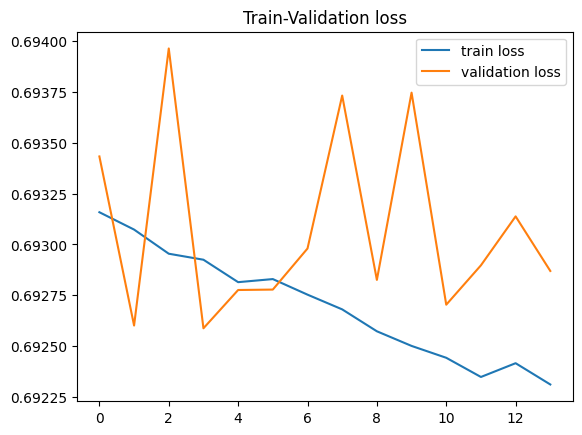

In [23]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_to1'
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [24]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5255102040816326, 'precision': 0.5255102040816326, 'f1': 0.5255102040816326, 'accuracy': 0.5255102040816326}
MALE {'recall': 0.09635416666666667, 'precision': 0.09635416666666667, 'f1': 0.09635416666666666, 'accuracy': 0.09635416666666667}
FEMALE {'recall': 0.9375, 'precision': 0.9375, 'f1': 0.9375, 'accuracy': 0.9375} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5214646464646465, 'precision': 0.5214646464646465, 'f1': 0.5214646464646465, 'accuracy': 0.5214646464646465}
MALE {'recall': 0.15328467153284672, 'precision': 0.15328467153284672, 'f1': 0.15328467153284672, 'accuracy': 0.15328467153284672}
FEMALE {'recall': 0.9186351706036745, 'precision': 0.9186351706036745, 'f1': 0.9186351706036745, 'accuracy': 0.9186351706036745} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5097783572359843, 'precision': 0.5097783572359843, 'f1': 0.5097783572359843, 'accuracy': 0.5097783572359843}
MALE {'r

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931646579441708 	 Validation loss: 0.6927735239772473 	 
  1%|          | 574/57400 [00:10<15:23, 61.52it/s]
Epoch 2 	 Training loss: 0.6930922322779998 	 Validation loss: 0.6929646690013045 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:20<15:05, 62.14it/s]
Epoch 3 	 Training loss: 0.6930530737916767 	 Validation loss: 0.6931113540116003 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:30<14:52, 62.42it/s]
Epoch 4 	 Training loss: 0.6929769393459014 	 Validation loss: 0.6932987621275045 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:40<14:31, 63.21it/s]
Epoch 5 	 Training loss: 0.6928769360435965 	 Validation loss: 0.6929646255606312 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:49<14:23, 63.14it/s]
Epoch 6 	 Training loss: 0.6928085432443054 	 Validation loss: 0.6925907286546998 	 
  6%|▌         | 3444/57400 [00:59<13:54, 64.66it/s]
Epoch 7 	 Training loss: 0.6927313695593578 	 Validation 

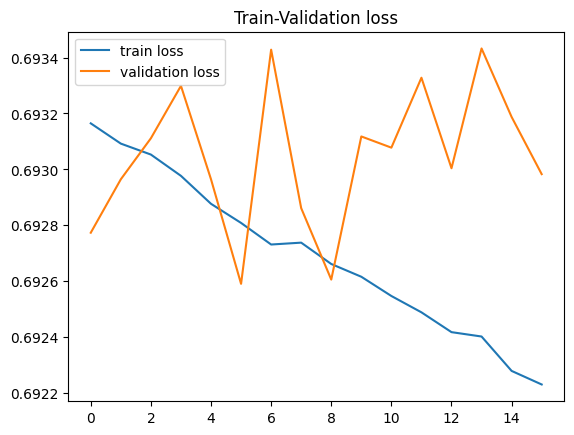

In [25]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_to2'
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [26]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5216836734693877, 'precision': 0.5216836734693877, 'f1': 0.5216836734693877, 'accuracy': 0.5216836734693877}
MALE {'recall': 0.078125, 'precision': 0.078125, 'f1': 0.078125, 'accuracy': 0.078125}
FEMALE {'recall': 0.9475, 'precision': 0.9475, 'f1': 0.9475, 'accuracy': 0.9475} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5012626262626263, 'precision': 0.5012626262626263, 'f1': 0.5012626262626263, 'accuracy': 0.5012626262626263}
MALE {'recall': 0.09975669099756691, 'precision': 0.09975669099756691, 'f1': 0.09975669099756691, 'accuracy': 0.09975669099756691}
FEMALE {'recall': 0.9343832020997376, 'precision': 0.9343832020997376, 'f1': 0.9343832020997376, 'accuracy': 0.9343832020997376} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.49674054758800523, 'precision': 0.49674054758800523, 'f1': 0.49674054758800523, 'accuracy': 0.49674054758800523}
MALE {'recall': 0.06060606060606061, 'precision'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931703631678525 	 Validation loss: 0.6931331814345667 	 
  1%|          | 574/57400 [00:10<15:05, 62.74it/s]
Epoch 2 	 Training loss: 0.6931116793836866 	 Validation loss: 0.692912514937126 	 
  2%|▏         | 1148/57400 [00:20<14:50, 63.18it/s]
Epoch 3 	 Training loss: 0.6929756901405414 	 Validation loss: 0.6932963132858276 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:30<14:21, 64.62it/s]
Epoch 4 	 Training loss: 0.6929313475038947 	 Validation loss: 0.692564196505789 	 
  4%|▍         | 2296/57400 [00:40<14:32, 63.16it/s]
Epoch 5 	 Training loss: 0.692904552620047 	 Validation loss: 0.6932493397745035 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:50<14:37, 62.17it/s]
Epoch 6 	 Training loss: 0.6927413931084011 	 Validation loss: 0.6928338640827244 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [01:00<14:07, 63.66it/s]
Epoch 7 	 Training loss: 0.6927412233286203 	 Validation loss: 0.6935168221845465 	 

3 e

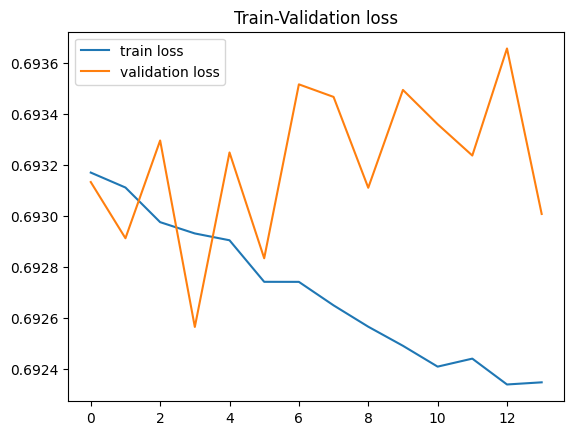

In [27]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_to3'
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [28]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5114795918367347, 'precision': 0.5114795918367347, 'f1': 0.5114795918367347, 'accuracy': 0.5114795918367347}
MALE {'recall': 0.0078125, 'precision': 0.0078125, 'f1': 0.0078125, 'accuracy': 0.0078125}
FEMALE {'recall': 0.995, 'precision': 0.995, 'f1': 0.995, 'accuracy': 0.995} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0170316301703163, 'precision': 0.0170316301703163, 'f1': 0.0170316301703163, 'accuracy': 0.0170316301703163}
FEMALE {'recall': 0.9816272965879265, 'precision': 0.9816272965879265, 'f1': 0.9816272965879265, 'accuracy': 0.9816272965879265} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4810951760104302, 'precision': 0.4810951760104302, 'f1': 0.4810951760104302, 'accuracy': 0.4810951760104302}
MALE {'recall': 0.005050505050505051, 'precision': 0.005

In [29]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5195578231292517, 'precision': 0.5195578231292517, 'f1': 0.5195578231292517, 'accuracy': 0.5195578231292517}
Métricas etiqueta male: {'recall': 0.06076388888888889, 'precision': 0.06076388888888889, 'f1': 0.06076388888888889, 'accuracy': 0.06076388888888889}
Métricas etiqueta female:  {'recall': 0.96, 'precision': 0.96, 'f1': 0.96, 'accuracy': 0.96}

 to
Resultado global: {'recall': 0.5012626262626263, 'precision': 0.5012626262626263, 'f1': 0.5012626262626263, 'accuracy': 0.5012626262626263}
Métricas etiqueta male: {'recall': 0.09002433090024331, 'precision': 0.09002433090024331, 'f1': 0.09002433090024331, 'accuracy': 0.09002433090024331}
Métricas etiqueta female:  {'recall': 0.9448818897637795, 'precision': 0.9448818897637795, 'f1': 0.9448818897637795, 'accuracy': 0.9448818897637795}

 as
Resultado global: {'recall': 0.49587136027813994, 'precision': 0.49587136027813994, 'f1': 0.49587136027813994, 'accuracy': 0.49587136027813

# AS

In [30]:
max_sequence_len = 15088
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931294020044679 	 Validation loss: 0.6932241411532386 	 
  1%|          | 574/57400 [00:10<14:53, 63.63it/s]
Epoch 2 	 Training loss: 0.6929433616819282 	 Validation loss: 0.6929654236567222 	 
  2%|▏         | 1148/57400 [00:20<14:47, 63.37it/s]
Epoch 3 	 Training loss: 0.6927653116008546 	 Validation loss: 0.6929097579697431 	 
  3%|▎         | 1722/57400 [00:30<15:05, 61.46it/s]
Epoch 4 	 Training loss: 0.6925831180624015 	 Validation loss: 0.6932193717714084 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:40<14:30, 63.28it/s]
Epoch 5 	 Training loss: 0.6923948583494911 	 Validation loss: 0.6926715717477313 	 
  5%|▌         | 2870/57400 [00:49<14:14, 63.82it/s]
Epoch 6 	 Training loss: 0.6922239988315396 	 Validation loss: 0.6925137204638983 	 
  6%|▌         | 3444/57400 [01:00<14:23, 62.45it/s]
Epoch 7 	 Training loss: 0.692028008167752 	 Validation loss: 0.6924464177277129 	 
  7%|▋         | 4018/57400 [01:10<14:23, 61.84it/s]
Epoch 8

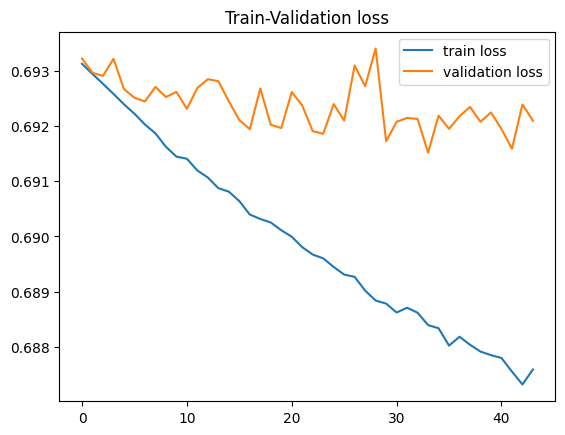

In [31]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_as1'
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [32]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.48596938775510207, 'precision': 0.48596938775510207, 'f1': 0.48596938775510207, 'accuracy': 0.48596938775510207}
MALE {'recall': 0.484375, 'precision': 0.484375, 'f1': 0.484375, 'accuracy': 0.484375}
FEMALE {'recall': 0.4875, 'precision': 0.4875, 'f1': 0.4875, 'accuracy': 0.4875} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5934343434343434, 'precision': 0.5934343434343434, 'f1': 0.5934343434343434, 'accuracy': 0.5934343434343434}
MALE {'recall': 0.6301703163017032, 'precision': 0.6301703163017032, 'f1': 0.6301703163017032, 'accuracy': 0.6301703163017032}
FEMALE {'recall': 0.5538057742782152, 'precision': 0.5538057742782152, 'f1': 0.5538057742782152, 'accuracy': 0.5538057742782152} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6127770534550195, 'precision': 0.6127770534550195, 'f1': 0.6127770534550195, 'accuracy': 0.6127770534550195}
MALE {'recall': 0.547979797979798, 'precision': 0.54

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931166510756422 	 Validation loss: 0.6927644095178378 	 
  1%|          | 574/57400 [00:10<15:05, 62.75it/s]
Epoch 2 	 Training loss: 0.6929082770796188 	 Validation loss: 0.6925577885013515 	 
  2%|▏         | 1148/57400 [00:20<14:49, 63.25it/s]
Epoch 3 	 Training loss: 0.6927463602313597 	 Validation loss: 0.693337460695687 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:30<14:24, 64.42it/s]
Epoch 4 	 Training loss: 0.6925223139520306 	 Validation loss: 0.6924656669972307 	 
  4%|▍         | 2296/57400 [00:40<14:38, 62.74it/s]
Epoch 5 	 Training loss: 0.6923651814668436 	 Validation loss: 0.692851866705943 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:50<14:05, 64.50it/s]
Epoch 6 	 Training loss: 0.6921764982909691 	 Validation loss: 0.6925067820791471 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [01:00<14:17, 62.90it/s]
Epoch 7 	 Training loss: 0.6919857440094499 	 Validation loss: 0.6929707001831572 	 

3 

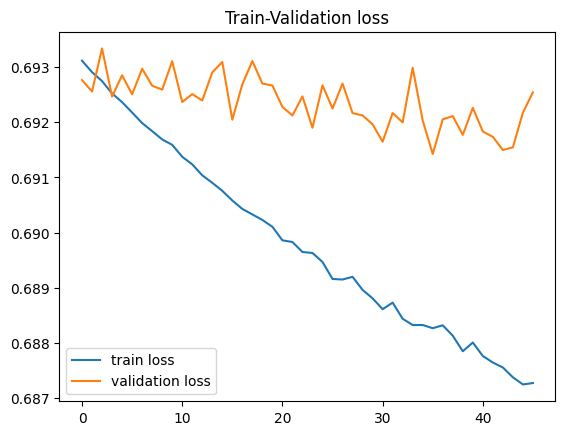

In [33]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_as2'
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [34]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.47959183673469385, 'precision': 0.47959183673469385, 'f1': 0.47959183673469385, 'accuracy': 0.47959183673469385}
MALE {'recall': 0.4947916666666667, 'precision': 0.4947916666666667, 'f1': 0.4947916666666667, 'accuracy': 0.4947916666666667}
FEMALE {'recall': 0.465, 'precision': 0.465, 'f1': 0.465, 'accuracy': 0.465} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5858585858585859, 'precision': 0.5858585858585859, 'f1': 0.5858585858585859, 'accuracy': 0.5858585858585859}
MALE {'recall': 0.6301703163017032, 'precision': 0.6301703163017032, 'f1': 0.6301703163017032, 'accuracy': 0.6301703163017032}
FEMALE {'recall': 0.5380577427821522, 'precision': 0.5380577427821522, 'f1': 0.5380577427821522, 'accuracy': 0.5380577427821522} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5867014341590613, 'precision': 0.5867014341590613, 'f1': 0.5867014341590613, 'accuracy': 0.5867014341590613}
MALE {'recall': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693137839799974 	 Validation loss: 0.6932519563173843 	 
  1%|          | 574/57400 [00:09<14:58, 63.25it/s]
Epoch 2 	 Training loss: 0.6929456192857297 	 Validation loss: 0.6931191753532927 	 
  2%|▏         | 1148/57400 [00:19<14:46, 63.42it/s]
Epoch 3 	 Training loss: 0.6927473266780999 	 Validation loss: 0.6927459916826022 	 
  3%|▎         | 1722/57400 [00:29<14:35, 63.62it/s]
Epoch 4 	 Training loss: 0.6925684085914067 	 Validation loss: 0.6928534527956429 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:39<14:21, 63.98it/s]
Epoch 5 	 Training loss: 0.6923372751744367 	 Validation loss: 0.6923440381632013 	 
  5%|▌         | 2870/57400 [00:49<14:38, 62.10it/s]
Epoch 6 	 Training loss: 0.6921529713823404 	 Validation loss: 0.6924671389288821 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [01:00<14:24, 62.44it/s]
Epoch 7 	 Training loss: 0.6919786727594581 	 Validation loss: 0.6924404299865334 	 

2 epoch without improvement
  

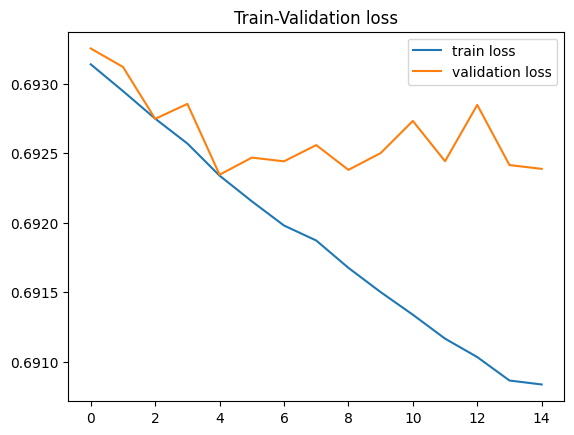

In [35]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_as3'
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [36]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.49489795918367346, 'precision': 0.49489795918367346, 'f1': 0.49489795918367346, 'accuracy': 0.49489795918367346}
MALE {'recall': 0.044270833333333336, 'precision': 0.044270833333333336, 'f1': 0.044270833333333336, 'accuracy': 0.044270833333333336}
FEMALE {'recall': 0.9275, 'precision': 0.9275, 'f1': 0.9275, 'accuracy': 0.9275} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.49242424242424243, 'precision': 0.49242424242424243, 'f1': 0.49242424242424243, 'accuracy': 0.49242424242424243}
MALE {'recall': 0.04866180048661801, 'precision': 0.04866180048661801, 'f1': 0.04866180048661801, 'accuracy': 0.04866180048661801}
FEMALE {'recall': 0.9711286089238845, 'precision': 0.9711286089238845, 'f1': 0.9711286089238845, 'accuracy': 0.9711286089238845} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5071707953063885, 'precision': 0.5071707953063885, 'f1': 0.5071707953063885, 'accuracy': 0.50717079530638

In [37]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.48681972789115646, 'precision': 0.48681972789115646, 'f1': 0.48681972789115646, 'accuracy': 0.48681972789115646}
Métricas etiqueta male: {'recall': 0.3411458333333333, 'precision': 0.3411458333333333, 'f1': 0.3411458333333333, 'accuracy': 0.3411458333333333}
Métricas etiqueta female:  {'recall': 0.6266666666666667, 'precision': 0.6266666666666667, 'f1': 0.6266666666666667, 'accuracy': 0.6266666666666667}

 to
Resultado global: {'recall': 0.5572390572390572, 'precision': 0.5572390572390572, 'f1': 0.5572390572390572, 'accuracy': 0.5572390572390572}
Métricas etiqueta male: {'recall': 0.43633414436334145, 'precision': 0.43633414436334145, 'f1': 0.43633414436334145, 'accuracy': 0.43633414436334145}
Métricas etiqueta female:  {'recall': 0.6876640419947506, 'precision': 0.6876640419947506, 'f1': 0.6876640419947506, 'accuracy': 0.6876640419947506}

 as
Resultado global: {'recall': 0.5688830943068232, 'precision': 0.5688830943068232, '